In [1]:
import torch
batch_size = 512
epochs = 100
device = torch.device("cuda:0")
bs_list = [1000, 2000, 3000, 5000, 10000, 20000]

In [2]:
import torchvision
import torchvision.transforms as transforms
#from torchvision.models.resnet import resnet18
import torch
from ResNet import *


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torch.nn as nn

class Loss(object):
    '''
    Class for counting loss
    '''

    def __init__(self, scores = None, is_adaptive = False, adaptive_type = 'mean'):
        self.scores = scores
        self.is_adaptive = is_adaptive
        self.adaptive_type = adaptive_type
        self.alpha = 0.5
        self.max_T = 200
        self.min_T = 10
        
    def get_T(self, data_scores):
        max_T = self.max_T
        min_T = self.min_T
        max_index = self.scores.max().cpu()
        if self.is_adaptive :
            T = (max_T - min_T) / max_index * data_scores.cpu()
            if self.adaptive_type == 'mean':
                return T.mean().int()
            if self.adaptive_type == 'full':
                return T.int()
            if self.adaptive_type == 'max':
                return T.max().int()
        return torch.Tensor([100])
    
    
    def calculate_loss(self, outputs, labels, teacher_output = None, data_scores = None, device = torch.device("cuda:0")):
        if self.scores is None:
            return nn.CrossEntropyLoss()(outputs, labels)
        else :
            T = self.get_T(data_scores).int()
            if self.adaptive_type == 'full' :
                h, w = outputs.shape
                T = [T.tolist()]*w
                T = torch.Tensor(T)
                T = torch.reshape(torch.Tensor(T),(h, w))
                T_mean = T.mean()
            else:
                T_mean = T
                
            T[T < self.min_T] = self.min_T
            T = T.to(device)

            T_mean = T_mean.to(device)
            
            T.requires_grad = False
            T_mean.requires_grad = False
            
            model_output = outputs / T
            teacher_output = teacher_output / T
            KD_loss = nn.KLDivLoss()(F.log_softmax(model_output, dim=1),
                             F.softmax(teacher_output, dim=1)) * (self.alpha * T_mean * T_mean) + \
              F.cross_entropy(outputs, labels) * (1. - self.alpha)
            return KD_loss
        
    

In [9]:
import numpy as np
import torch.optim as optim
from IPython.display import clear_output
import matplotlib.pyplot as plt

def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def test(model, test_loader, device):
    acc = 0
    for x, labels in test_loader:
        x, labels = x.to(device), labels.to(device)
        outputs = model(x)
        pred = outputs.argmax(dim=1, keepdim=True) 
        acc += pred.eq(labels.view_as(pred)).sum().item()
    acc = acc / len(test_loader.dataset)
    
    return acc

def train_and_validate(model, train_loader, test_loader, epochs, device):
    model.train()
    lr = 0.1
    optimizer = optim.SGD(model.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    
    loss_per_epoch_list = []
    loss_function = Loss()
    
    for epoch in range(epochs):
        loss_list = []    
            
        for x, labels in train_loader:
            x, labels = x.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(x)
            loss = loss_function.calculate_loss(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
    
        loss_per_epoch_list.append(np.mean(loss_list))
        scheduler.step()
        
        clear_output(wait=False)
        plt.plot(loss_per_epoch_list)
        plt.show()
        
    return loss_per_epoch_list, test(model, test_loader, device)
    
            
        
def train_and_validate_with_teacher_and_scores(model, teacher, scores, train_loader, test_loader, epochs, device, is_adaptive = True, adaptive_type = 'mean'):
    model.train()
    lr = 0.1
    optimizer = optim.SGD(model.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    
    loss_per_epoch_list = []
    loss_function = Loss(scores = scores, is_adaptive = is_adaptive, adaptive_type = adaptive_type)
    
    for epoch in range(epochs):
        loss_list = []  
        print(f'{epoch + 1} / {epochs}')         
            
        for x, labels, score in train_loader:
            x, labels = x.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(x)
            
            teacher_output = teacher(x)
            loss = loss_function.calculate_loss(outputs, labels, teacher_output, score).cpu()
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
    
        loss_per_epoch_list.append(np.mean(loss_list))
        scheduler.step()
        
        clear_output(wait=False)
        plt.plot(loss_per_epoch_list)
        plt.title(adaptive_type if is_adaptive else 'const' )
        plt.show()
        
    return loss_per_epoch_list, test(model, test_loader, device)

## Train simple model

train teacher

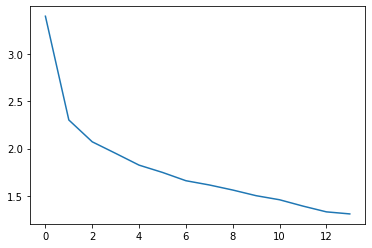

In [ ]:
#device = torch.device("cuda:0")

testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

teacher_loss_list = []
teacher_acc_list  = []
for bs in bs_list:
    model = ResNet18()
    model.load_state_dict(torch.load('ResNet18_student.pt'))
    model.to(device)
    model.train()
    
    bs_trainset, _ = torch.utils.data.random_split(trainset, [bs, trainset.__len__() - bs])
    trainloader = torch.utils.data.DataLoader(bs_trainset, batch_size=batch_size, shuffle=True)
    loss_per_epoch_list, acc = train_and_validate(model, trainloader, testloader, epochs, device)
    teacher_loss_list.append(loss_per_epoch_list[-1])
    teacher_acc_list.append(acc)

#torch.save(model.state_dict(), 'ResNet18_teacher.pt')

In [8]:
teacher_acc_list

[0.3677, 0.4651, 0.5021, 0.6269, 0.771, 0.8474]

## Train with teacher and scores

In [10]:
import numpy as np

scores = torch.Tensor(np.load('cifar_forg.npy')).to(device)

teacher = ResNet18()
teacher.load_state_dict(torch.load(f'ResNet18_teacher.pt')) 
teacher.to(device)
teacher.eval()
freeze_model(teacher)
test(teacher, testloader, device)

0.9013

In [11]:
from torch.utils.data import Dataset, DataLoader

class IndexData(Dataset):
    def __init__(self, dataset, scores_data, indices=None):
        self.data = dataset
        self.indices = (
            indices if indices is not None else np.arange(len(dataset))
        )
        self.scores_data = scores_data

    def __getitem__(self, index):
        index = self.indices[index]
        data, target = self.data[index]
        return data, target, self.scores_data[index]

    def __len__(self):
        return len(self.indices)

In [12]:
def train_with_idx(indexData, adaptive_type):
    trainloader = torch.utils.data.DataLoader(indexData, batch_size=batch_size, shuffle=True)
    model = ResNet18()
    model.load_state_dict(torch.load('ResNet18_student.pt'))
    model.to(device)
    model.train()
    
    loss, acc = train_and_validate_with_teacher_and_scores(model, teacher, scores, trainloader, testloader, epochs, device, is_adaptive = True, adaptive_type = adaptive_type)
    return loss, acc

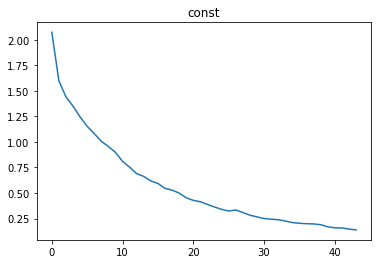

45 / 100


In [ ]:

acc_list = {}
loss_list = {}


acc_list['mean'] = []
loss_list['mean'] = []

acc_list['full'] = []
loss_list['full'] = []

acc_list['const'] = []
loss_list['const'] = []

for bs in bs_list:
    print(bs)
    random_indexes = np.random.choice(range(scores.shape[0]), size=bs, replace=False)
    indexData = IndexData(trainset, scores, random_indexes)
    
    # считаем для каждого объекта свою температуру
    adaptive_type = 'full'
    loss, acc = train_with_idx(indexData, adaptive_type)
    acc_list[adaptive_type].append(acc)
    loss_list[adaptive_type].append(loss[-1])
    

    # берем температуру как среднее
    adaptive_type = 'mean'
    loss, acc = train_with_idx(indexData, adaptive_type)
    acc_list[adaptive_type].append(acc)
    loss_list[adaptive_type].append(loss[-1])
    
    # не меняем температуру
    adaptive_type = 'const'
    loss, acc = train_with_idx(indexData, adaptive_type)
    acc_list[adaptive_type].append(acc)
    loss_list[adaptive_type].append(loss[-1])


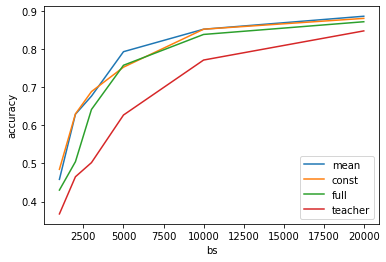

In [15]:
plt.plot(bs_list, acc_list['mean'], label = 'mean')
plt.plot(bs_list, acc_list['const'], label = 'const')
plt.plot(bs_list, acc_list['full'], label = 'full')
plt.plot(bs_list, teacher_acc_list, label = 'teacher')
plt.legend()
plt.xlabel('bs')
plt.ylabel('accuracy')
plt.show()